In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "7890845021",
                             database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located


In [2]:
query =""" select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns =[ "city"])
df.head()  # use for print 5 count

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [3]:
query =""" select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()


"total orders placed in 2017 are ", data[0][0]

('total orders placed in 2017 are ', 225505)

# Find the total sales per category.

In [4]:
query ="""select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
# using upper to convert upper
# using round to count up to 2 decimal



cur.execute(query)

data = cur.fetchall()

#data  #----------------    normal data

# data visualisation
df = pd.DataFrame(data , columns = ["Category", "sales"])
df

,Category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [17]:
query =""" select (sum( case when payment_installments >= 1 then 1 
else 0 end)) / count(*)*100 from payments """

# using sum adding all payments instllments
# 
cur.execute(query)

data = cur.fetchall()

"Calculate the percentage of orders that were paid in installments", data [0][0]

('Calculate the percentage of orders that were paid in installments',
 Decimal('99.9981'))

# Count the number of customers from each state

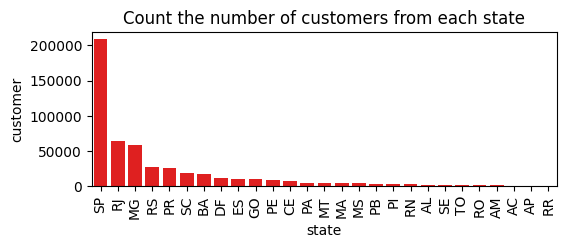

In [18]:
query =""" select customer_state , count(customer_id) 
from  customers group by customer_state  """

# using sum adding all payments instllments
# 
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state","customer"])
df = df.sort_values(by = "customer",ascending= False)

plt.figure(figsize = (6,2))
sns.barplot(x = df["state"],y = df["customer"],color="red")

plt.title("Count the number of customers from each state")  #using for title bar
plt.xticks(rotation=90)
plt.show()


# Calculate the number of orders per month in 2018.

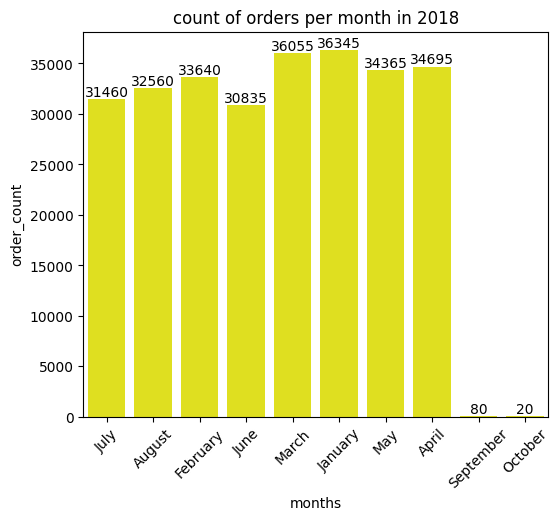

In [19]:

query ="""select monthname (order_purchase_timestamp) months, 
count(order_id) order_count
from orders where year (order_purchase_timestamp) = 2018 
group by months"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["months","order_count"])
#o = ["january","february","march","april","may","june","july","august","september","october","november","december"]


#sns.barplot(x = df["months"],y = df["order_count"],data = df, order = o)

plt.figure(figsize = (6,5))
ax = sns.barplot(x=df["months"],y=df["order_count"],color = "yellow")

plt.xticks(rotation=45)

plt.title("count of orders per month in 2018")

ax.bar_label(ax.containers[0])   #using ax for barlabel 

plt.show()


# Find the average number of products per order, grouped by customer city

In [20]:
query ="""with count_per_order as
(select orders.order_id, orders.customer_id, 
count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_order desc
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["city","average ptoduct per orders"])
df.head(10)

,city,average ptoduct per orders
0,padre carvalho,35.00
1,celso ramos,32.50
2,datas,30.00
3,candido godoi,30.00
4,matias olimpio,25.00
5,cidelandia,20.00
6,curralinho,20.00
7,picarra,20.00
8,morro de sao paulo,20.00
9,teixeira soares,20.00


# Calculate the percentage of total revenue contributed by each product category


In [23]:
query ="""select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments)*100),2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["category","sales_percentage"])
df.head()

,category,sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


 # Identify the correlation between product price and the number of times a product has been purchased

In [34]:
import numpy as np


query ="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["category","order_count","price"])


arr1=df["order_count"]
arr2=df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of product has been purchased is",a[0][-1])

the correlation between price and number of product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue


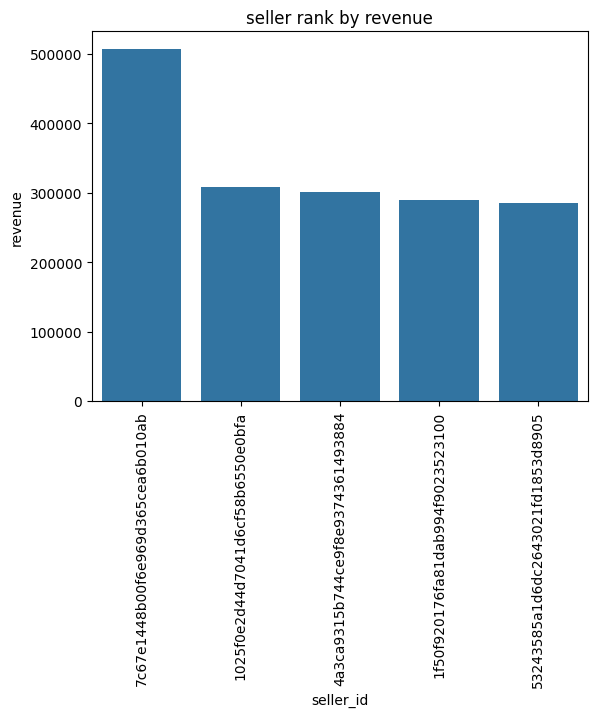

In [9]:
query ="""select * ,rank() over (order by revenue desc)as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id","revenue","rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue",data = df)
plt.xticks(rotation = 90)
plt.title("seller rank by revenue")
plt.show()


# Calculate the moving average of order values for each customer over their order history


In [24]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
519425,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
519426,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
519427,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
519428,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.


In [15]:
query = """
select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from

(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","months","payment","cummulative_value"])
df


,years,months,payment,cummulative_value
0,2016,9,1261.20,1261.20
1,2016,10,295452.40,296713.60
2,2016,12,98.10,296811.70
3,2017,1,692440.20,989251.90
4,2017,2,1459540.05,2448791.95
5,2017,3,2249318.00,4698109.95
6,2017,4,2088940.15,6787050.10
7,2017,5,2964594.10,9751644.20
8,2017,6,2556381.90,12308026.10
9,2017,7,2961914.60,15269940.70


# Calculate the year-over-year growth rate of total sales.

In [25]:
query = """
with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders join payments
on orders.order_id = payments.order_id
group by years order by years )

select years,
(( payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years) )
from a

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,121.127038
2,2018,0.200009


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [26]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

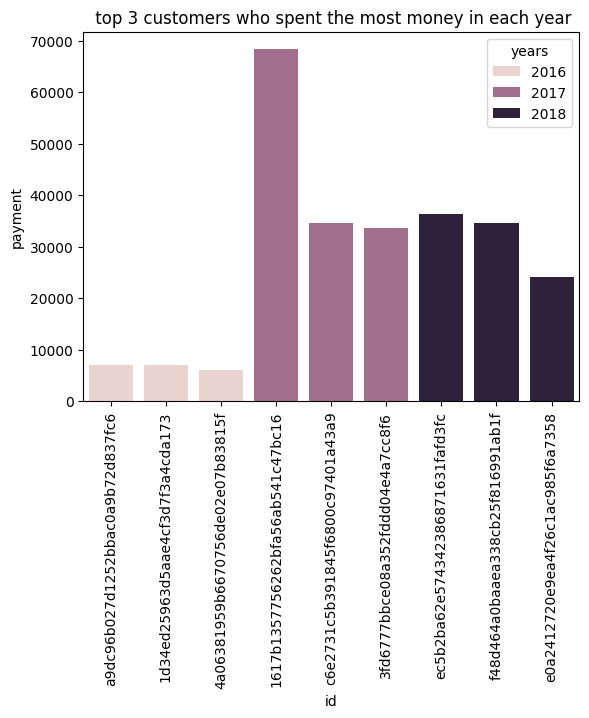

In [28]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.title(" top 3 customers who spent the most money in each year")
plt.show()